# Градиентный бустинг над решающими деревьями
Данное задание основано на материалах лекций по композициям алгоритмов.
## Вы научитесь: 
*	работать с градиентным бустингом и подбирать его гиперпараметры
*	сравнивать разные способы построения композиций
*	понимать, в каком случае лучше использовать случайный лес, а в каком — градиентный бустинг
*	использовать метрику log-loss

## Введение
Построение композиции — важный подход в машинном обучении, который позволяет объединять большое количество слабых алгоритмов в один сильный. Данный подход широко используется на практике в самых разных задачах.
На лекциях был рассмотрен метод градиентного бустинга, который последовательно строит композицию алгоритмов, причем каждый следующий алгоритм выбирается так, чтобы исправлять ошибки уже имеющейся композиции. Обычно в качестве базовых алгоритмов используют деревья небольшой глубины, поскольку их достаточно легко строить, и при этом они дают нелинейные разделяющие поверхности.
Другой метод построения композиций — случайный лес. В нем, в отличие от градиентного бустинга, отдельные деревья строятся независимо и без каких-либо ограничений на глубину — дерево наращивается до тех пор, пока не покажет наилучшее качество на обучающей выборке.

В этом задании мы будем иметь дело с задачей классификации. В качестве функции потерь будем использовать log-loss:

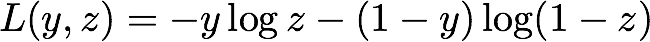

Здесь через y обозначен истинный ответ, через z — прогноз алгоритма. Данная функция является дифференцируемой, и поэтому подходит для использования в градиентном бустинге. Также можно показать, что при ее использовании итоговый алгоритм будет приближать истинные вероятности классов.

## Реализация в Sklearn:
Загрузим выборку из файла gbm-data.csv с помощью pandas и преобразуем ее в массив numpy (параметр values у датафрейма). В первой колонке файла с данными записано, была или нет реакция. 

Все остальные колонки (d1 - d1776) содержат различные характеристики молекулы, такие как размер, форма и т.д. Разобьём выборку на обучающую и тестовую, используя функцию train_test_split с параметрами test_size = 0.8 и random_state = 241.


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('gbm-data.csv')
y = df['Activity'].values
X = df.loc[:, 'D1':'D1776'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

Реализуем сигмоидную функцию:

In [11]:
import math
def sigmoid(y_pred):
    return 1.0 / (1.0 + math.exp(-y_pred))

Реализуем метод для предсказания качества на обучающей и тестовой выборке на каждой итерации:

In [12]:
from sklearn.metrics import log_loss

def log_loss_results(model, X, y):
    results = []
    for pred in model.staged_decision_function(X):
        results.append(log_loss(y, [sigmoid(y_pred) for y_pred in pred]))
    return results

Реализуем функцию для отображения графика значений log-loss:

In [13]:
import matplotlib.pyplot as plt
def plot_loss(learning_rate, test_loss, train_loss):
    plt.figure()
    plt.plot(test_loss, 'r')
    plt.plot(train_loss, 'g',)
    plt.legend(['test', 'train'])
    min_loss_value = min(test_loss)
    min_loss_index = test_loss.index(min_loss_value)
    return min_loss_value, min_loss_index

Реализуем обучение GradientBoostClassifier с параметрами n_estimators=250, verbose=True, random_state=241 и для каждого значения learning_rate из списка [1, 0.5, 0.3, 0.2, 0.1]:

      Iter       Train Loss   Remaining Time 
         1           1.0190            9.15s
         2           0.9192            9.32s
         3           0.8272            8.71s
         4           0.7834            8.40s
         5           0.7109            8.15s
         6           0.6368            7.93s
         7           0.5797            7.80s
         8           0.5610            7.71s
         9           0.5185            7.62s
        10           0.4984            7.51s
        20           0.1999            6.93s
        30           0.1313            6.56s
        40           0.0790            6.22s
        50           0.0511            5.89s
        60           0.0352            5.60s
        70           0.0245            5.29s
        80           0.0162            4.99s
        90           0.0114            4.70s
       100           0.0077            4.41s
       200           0.0002            1.45s
      Iter       Train Loss   Remaining Time 
        

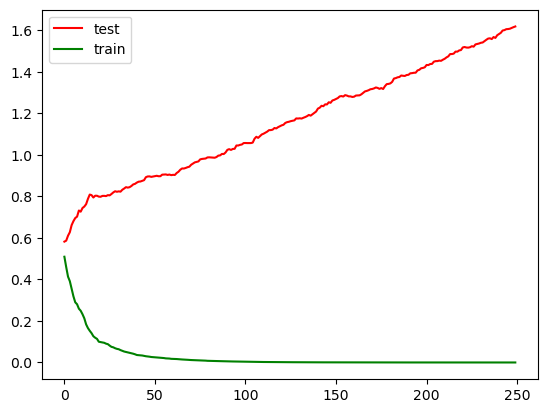

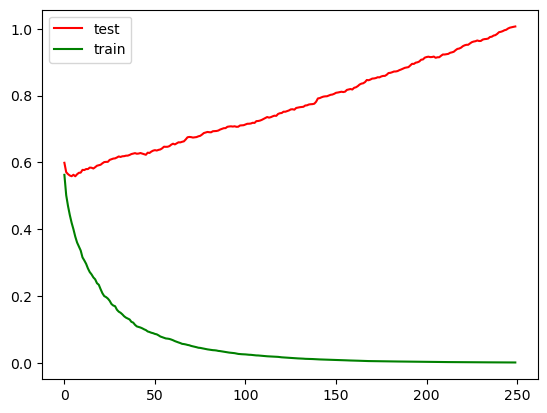

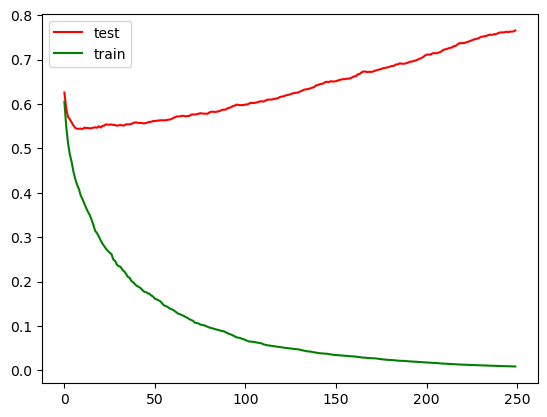

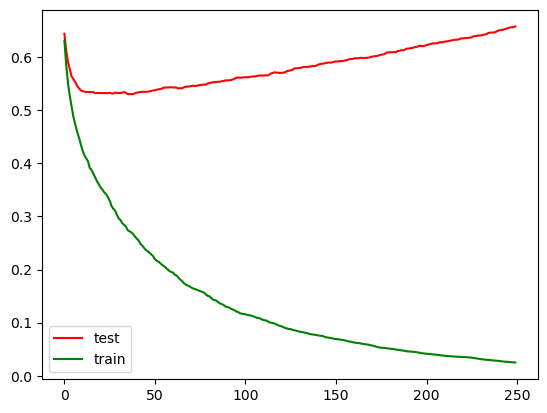

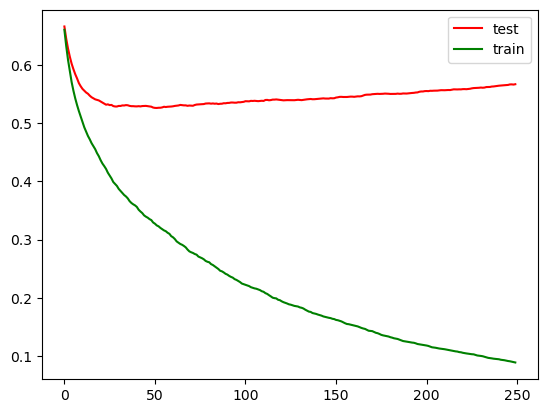

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
def model_test(learning_rate):
    model = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=250, verbose=True, random_state=241)
    model.fit(X_train, y_train)

    train_loss = log_loss_results(model, X_train, y_train)
    test_loss = log_loss_results(model, X_test, y_test)
    return plot_loss(learning_rate, test_loss, train_loss)

min_loss_results = {}
for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:
    min_loss_results[learning_rate] = model_test(learning_rate)\

print('Overfitting')

Минимальное значение log-loss и номер итерации, на котором оно достигается, при learning_rate = 0.2.

In [16]:
min_loss_value, min_loss_index = min_loss_results[0.2]
print(f'{min_loss_index}: {min_loss_value}')

36: 0.5301645204906471


На этих же данных обучим RandomForestClassifier с количеством деревьев, равным количеству итераций, на котором достигается наилучшее качество у градиентного бустинга из предыдущего пункта, c random_state=241 и остальными параметрами по умолчанию. Какое значение log-loss на тесте получается у этого случайного леса?

In [17]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=min_loss_index, random_state=241)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
test_loss = log_loss(y_test, y_pred)
print(test_loss)

0.5415685811957381
